In [1]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt

package_dir = "../src"
package_dir = os.path.dirname(package_dir)
if package_dir not in sys.path:
    sys.path.append(package_dir)

from src.sentinel2_handling.sentinel2_downloader import (
    query_sentinel2,
    filter_item_list,
)
import src.utils.img_utils as iu
import warnings

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# Intro: 
Punggol has changed dramatically over the years.. Using Sentinel2 data, I would like to visualize and explore the changes.

# Data Loading from Sentinel2

In [2]:
ns_bounds = [1.4234, 1.3831]  # lat
ew_bounds = [103.9323, 103.8853]  # long
bbox = [ew_bounds[1], ns_bounds[1], ew_bounds[0], ns_bounds[0]]

In [3]:
items = query_sentinel2(bbox=bbox, max_cloud_cover=85, num_days_before_end=4000)

In [21]:
filt_metadata, filt_item_procs = filter_item_list(items, bbox=bbox, min_usable_pct=80)

List filtered as 43 out of 348 items orginally


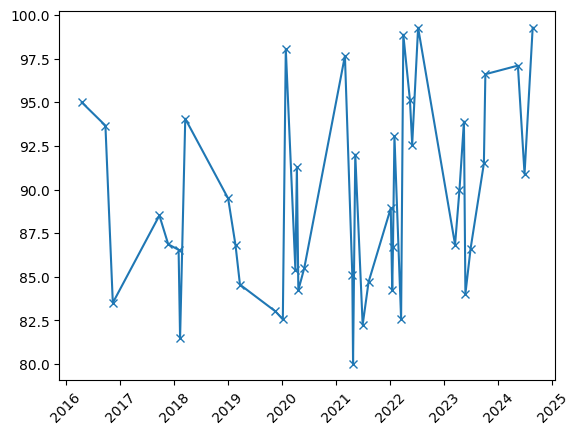

In [22]:
plt.figure()
x = []
y = []
for m in filt_metadata:
    x.append(dt.strptime(m[0], "%Y-%m-%d"))
    y.append(m[-1])
plt.plot(x, y, "-x")
plt.xticks(rotation=45);

In [24]:
num_items = len(filt_metadata)
for i in range(int(num_items / 5)):
    s = ""
    for k in range(5):
        ind = 5 * i + k
        if ind >= num_items:
            break
        s += f"({filt_metadata[ind][0]}, {filt_metadata[ind][-1]:.3f}),\t"
    print(s[:-2])

(2016-04-16, 94.992),	(2016-09-23, 93.662),	(2016-11-12, 83.509),	(2017-09-23, 88.515),	(2017-11-22, 86.861)
(2018-01-31, 86.549),	(2018-02-10, 81.471),	(2018-03-17, 94.058),	(2019-01-01, 89.490),	(2019-02-20, 86.808)
(2019-03-22, 84.554),	(2019-11-17, 83.021),	(2020-01-06, 82.561),	(2020-01-26, 98.051),	(2020-03-31, 85.376)
(2020-04-10, 91.287),	(2020-04-20, 84.237),	(2020-05-30, 85.502),	(2021-03-01, 97.654),	(2021-04-20, 85.091)
(2021-04-25, 80.027),	(2021-05-10, 91.998),	(2021-06-29, 82.249),	(2021-08-08, 84.702),	(2022-01-05, 88.931)
(2022-01-15, 84.218),	(2022-01-20, 86.692),	(2022-01-30, 93.040),	(2022-03-16, 82.569),	(2022-03-31, 98.866)
(2022-05-15, 95.100),	(2022-05-30, 92.578),	(2022-07-09, 99.270),	(2023-03-16, 86.842),	(2023-04-15, 89.998)
(2023-05-15, 93.894),	(2023-05-25, 84.025),	(2023-06-29, 86.614),	(2023-09-27, 91.495),	(2023-10-07, 96.604)


We want to get the highest usable percentage if there are multiple usable images per month

In [25]:
df = pd.DataFrame(filt_metadata, columns=["date", "eo_cloud_cover", "usable_pixels"])
df["year-month"] = df["date"].str[:7]

In [26]:
max_usable_pixs_per_month = (
    df.groupby("year-month").agg({"usable_pixels": "max"}).to_dict()["usable_pixels"]
)
df["is_best"] = df["usable_pixels"] == df["year-month"].map(max_usable_pixs_per_month)
print(f"need to drop {np.sum(~df['is_best'])} out of {len(df)} images")

need to drop 9 out of 43 images


In [27]:
inds_to_keep = set(df[df["is_best"]].index)

good_metadata = []
good_processors = []
for ii in range(num_items):
    if ii not in inds_to_keep:
        continue
    good_metadata.append(filt_metadata[ii])
    good_processors.append(filt_item_procs[ii])

print(len(good_metadata))

34


In [28]:
# compute indices:
[ip.load_and_compute_spectral_indices() for ip in good_processors];

# RGB composite timelapse

## manual adjustment of contrast and brightness

We try to get a nice colour contrast for a single reference image and use that to equalize the remaining images

In [51]:
img_with_lowest_usable_pixel_pct = np.argmin([m[-1] for m in good_metadata])

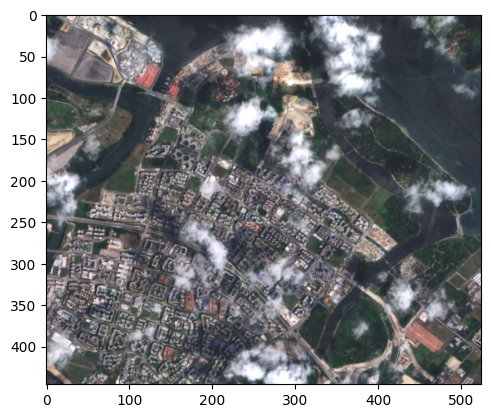

In [56]:
def apply_adjustments(raw_img):
    nimg = iu.normalize_image(raw_img)
    nimg = iu.apply_clahe(nimg, tile_grid_size=(10, 10))
    nimg = iu.adjust_contrast_brightness(nimg, contrast=1.05, brightness=0.1)
    # blue adjustment
    nimg[:, :, 2] = np.clip(nimg[:, :, 2] * 1.07 + 0.03, 0, 1)
    # green adjustment
    nimg[:, :, 1] = np.clip(nimg[:, :, 1] * 1.01 + 0.01, 0, 1)
    # red adjustment
    nimg[:, :, 0] = np.clip(nimg[:, :, 0], 0, 1)
    return nimg


plt.figure()
nimg = apply_adjustments(
    good_processors[img_with_lowest_usable_pixel_pct].spectral_indices.rgb_image.img
)
plt.imshow(nimg)

In [57]:
ref_image = apply_adjustments(
    good_processors[img_with_lowest_usable_pixel_pct].spectral_indices.rgb_image.img
)

## Visualization of equalization

In [58]:
test_img = iu.normalize_image(good_processors[3].spectral_indices.rgb_image.img)
matched_img = iu.match_images(ref_img=ref_image, src_img=test_img)

Text(0.5, 1.0, 'matched')

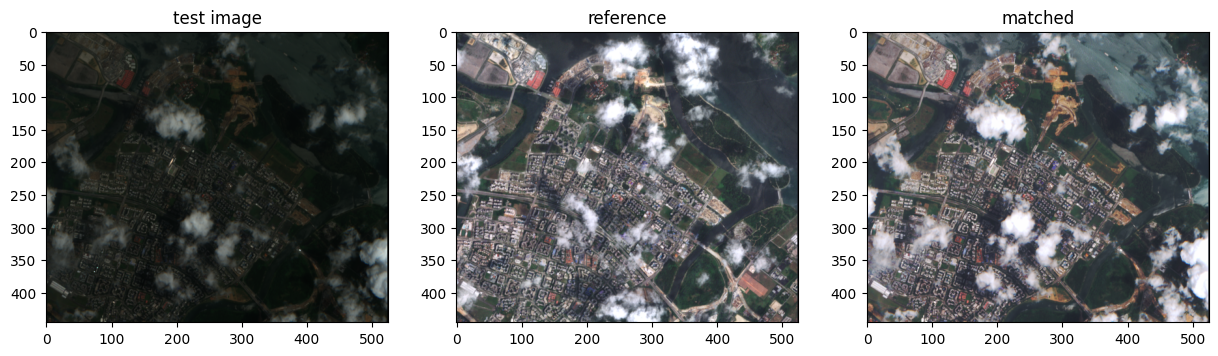

In [59]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_img)
plt.title("test image")
plt.subplot(1, 3, 2)
plt.imshow(ref_image)
plt.title("reference")
plt.subplot(1, 3, 3)
plt.imshow(matched_img)
plt.title("matched")

## Run equalization on all images

In [60]:
all_images = [
    iu.normalize_image(proc.spectral_indices.rgb_image.img) for proc in good_processors
]
matched_images = [iu.match_images(ref_img=ref_image, src_img=img) for img in all_images]
imgs_uint8 = [iu.convert_to_uint8(img) for img in matched_images]

Text(0.5, 1.0, 'matched (uint8)')

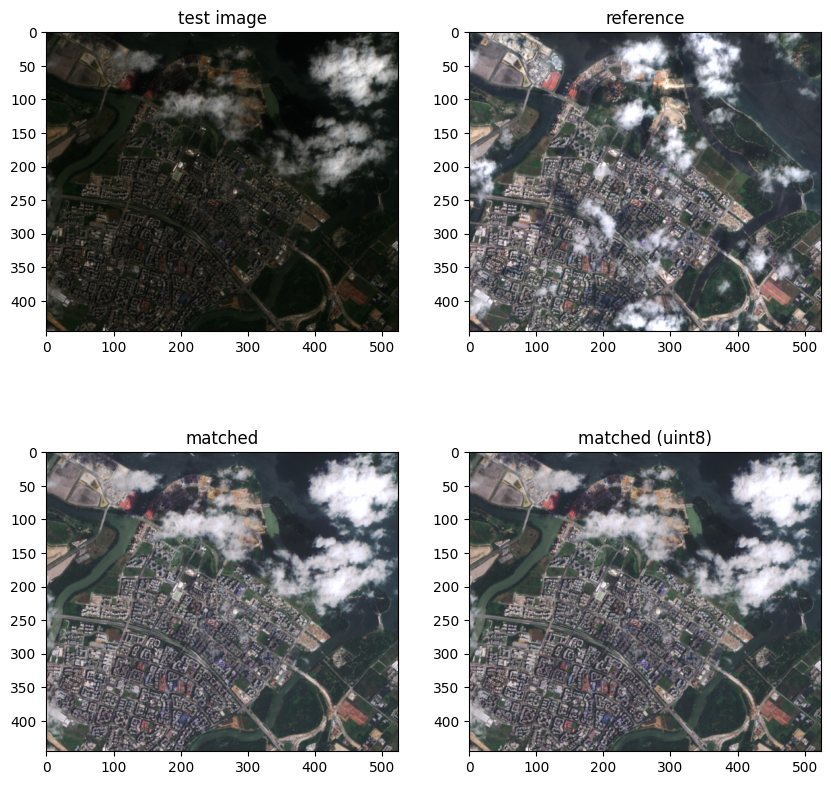

In [61]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(all_images[5])
plt.title("test image")
plt.subplot(2, 2, 2)
plt.imshow(ref_image)
plt.title("reference")
plt.subplot(2, 2, 3)
plt.imshow(matched_images[5])
plt.title("matched")
plt.subplot(2, 2, 4)
plt.imshow(imgs_uint8[5])
plt.title("matched (uint8)")

## output to gif \o/

### Testing annotation

Text(0.5, 1.0, 'annotated')

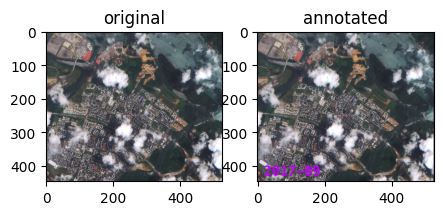

In [62]:
test_img = imgs_uint8[3]
test_text = good_metadata[3][0][:7]
nice_font = "../src/utils/MesloLGS NF Bold.ttf"
hex_color = "#be03fd"
nice_color = tuple(int(hex_color[i : i + 2], 16) for i in (1, 3, 5))
annotated_img = iu.add_annotation(
    test_img,
    test_text,
    font_path=nice_font,
    font_size=40,
    font_color=nice_color,
    position=(20, 390),
)

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.title("original")
plt.subplot(1, 2, 2)
plt.imshow(annotated_img)
plt.title("annotated")

### Annotate all and save to gif

In [63]:
nice_font = "../src/utils/MesloLGS NF Bold.ttf"
hex_color = "#be03fd"
nice_color = tuple(int(hex_color[i : i + 2], 16) for i in (1, 3, 5))

In [64]:
annotated_img_list = []
num_imgs = len(imgs_uint8)
for ind in range(num_imgs):
    img = imgs_uint8[ind]
    year_month = good_metadata[ind][0][:7]
    annotated_img_list.append(
        iu.add_annotation(
            img,
            text=year_month,
            font_path=nice_font,
            font_size=40,
            font_color=nice_color,
            position=(20, 390),
        )
    )

In [65]:
time_range_str = f"{good_metadata[0][0][:7]}_{good_metadata[-1][0][:7]}"
annotated_img_list[0].save(
    f"../visualizations/punggol_timelapse_{time_range_str}.gif",
    save_all=True,
    append_images=annotated_img_list[1:]
    + [annotated_img_list[-1]] * 5,  # add delay to last frame
    duration=150,
    loop=0,
)